# Offset calibration using the cross-talk effect in LinoSPAD2.

In this example, we are using cross-talk (CT) data collected with a green LED shinning upon the whole sensor
to calculate the offset calibration.

In LinoSPAD2, timestamping of the photons is done in the FPGA which is on a separate board from the sensor. Because of that, the electrical signals from SPADs have to travel some distance before we get a digital timestamp. There are 256 pixels and 64 time-to-digital converters (TDC) that are doing the timestamping. Different pixels has its own connection to a TDC. Time that takes for the signal to reach the FPGA from each SPAD is different and it is added to the timestamp. When calculating delays for the photon coincedences, an offset of $\Delta t \neq0$ in introduced, shifting the data.

Here, we look at the CT peaks between two consequent neighboring pixels (i.e., $i$ and $i+1$), fit the peak to extract its position and use these numbers to calculate the offset calibration.

In [1]:
# Import libraries
import matplotlib.pyplot as plt
from daplis.functions import cross_talk, fits, delta_t, utils, sensor_plot
import numpy as np
import os
from glob import glob

# Path to the '.dat' data files with the CT data
path = r"D:\LinoSPAD2\Data\B7d\2024.12.11\offset_w_LED"

We can plot the sensor population plot to see how the LED covers the array of pixels and what rates we see.


> > > Collecting data for sensor population plot,Working in D:\LinoSPAD2\Data\B7d\2024.12.11\offset_w_LED < < <




> > > Plotting < < <

Fitting the peaks with gaussian
> > > The plot is saved as '{plot_name}_single_file.png'in {os.getcwd()} < < <


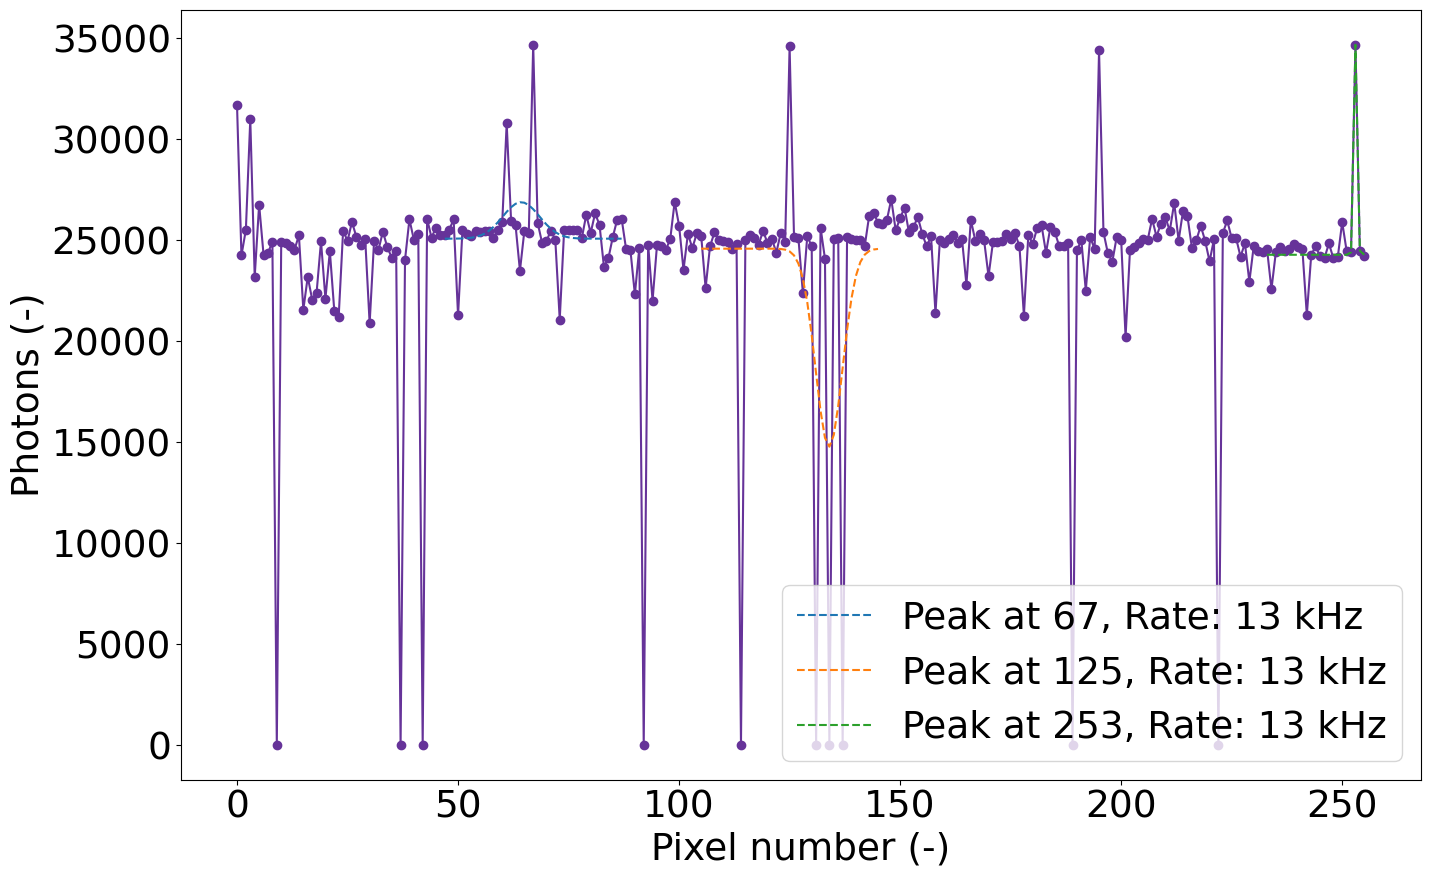

In [2]:
sensor_plot.plot_sensor_population(
    path,
    daughterboard_number="B7d",
    motherboard_number="#28",
    firmware_version="2212s",
    timestamps=100,
    single_file=True,
    fit_peaks=True,
    show_fig=True,
    threshold_multiplier=1.35
)

First, we calculate the delta ts --- or timestamp differences --- for the CT data. The "_mod" function is used, which calculates delta ts only for diagonals and not all vs all pixels provided.

In [ ]:
delta_t.calculate_and_save_timestamp_differences_fast_1v1(
    path,
    rewrite=True,
    pixels=[[x for x in range(255)], [x for x in range(1, 256)]],
    daughterboard_number="B7d",
    motherboard_number="#28",
    firmware_version="2212s",
    timestamps=100,
    # include_offset=True
)


> > > Collecting data for delta t plot for the requested pixels and saving it to .feather in a cycle < < <



File wasn't generated. Check input parameters.


After collecting the timestamp differences, we can plot the CT peaks and offset them to zero and visualise them. Here, we avoid pair of pixels where pixels 131 or 189 are present. These pixels are not responding (could be dead) and do not produce a CT peak. We will deal with them separately later.

In [5]:
# Generate a list of pixels' pairs
pixel_pairs = [[i, i + 1] for i in range(255)]

# List for peak positions
mus = []

avoid = [[130, 131], [131, 132], [188, 189], [189, 190]]

for pixel_pair in pixel_pairs:
    if pixel_pair in avoid:
        # Asign 0 to the ignored dead pixels
        mus.append(0)
        continue

    params = fits.fit_with_gaussian(
        path,
        pixels=pixel_pair,
        window=15e3,
        multiplier=7,
        return_fit_params=True,
    )

    plt.close('all')
    
    # Collect peaks' positions
    mus.append(params[f"{pixel_pair[0]},{pixel_pair[1]}"].iloc[0, 1])

We will cut out the not responding pixel completely, substituing the first equation for each with the next available neighbor, taking CT peak positions for pairs (130,132) and (188, 190).

First, we collect delta ts separately for each of these pairs.

## !!! WARNING !!!
Before running the following code, copy the '.feather' file in the "delta_ts_data" folder to a separate folder, running the next cell will rewrite it.

In [6]:
delta_t.calculate_and_save_timestamp_differences_fast(
    path,
    rewrite=True,
    pixels=[130, 132],
    daughterboard_number="B7d",
    motherboard_number="#28",
    firmware_version="2212s",
    timestamps=100,
    # include_offset=True
)


> > > Collecting data for delta t plot for the requested pixels and saving it to .feather in a cycle < < <




> > > Timestamp differences are saved as0000072934-0000073033.feather in D:\LinoSPAD2\Data\B7d\2024.12.11\offset_w_LED\delta_ts_data < < <


## !!! WARNING !!!
Before running the following code, copy the '.feather' file in the "delta_ts_data" folder to a separate folder, running the next cell will rewrite it.

In [7]:
delta_t.calculate_and_save_timestamp_differences_fast(
    path,
    rewrite=True,
    pixels=[188, 190],
    daughterboard_number="B7d",
    motherboard_number="#28",
    firmware_version="2212s",
    timestamps=100,
    # include_offset=True,
)


> > > Collecting data for delta t plot for the requested pixels and saving it to .feather in a cycle < < <




> > > Timestamp differences are saved as0000072934-0000073033.feather in D:\LinoSPAD2\Data\B7d\2024.12.11\offset_w_LED\delta_ts_data < < <


Now, we plot the CT peak for pairs (130,132) and (188, 190) and fit them with Gaussian to extract the peak position. We will use these numbers manually later.

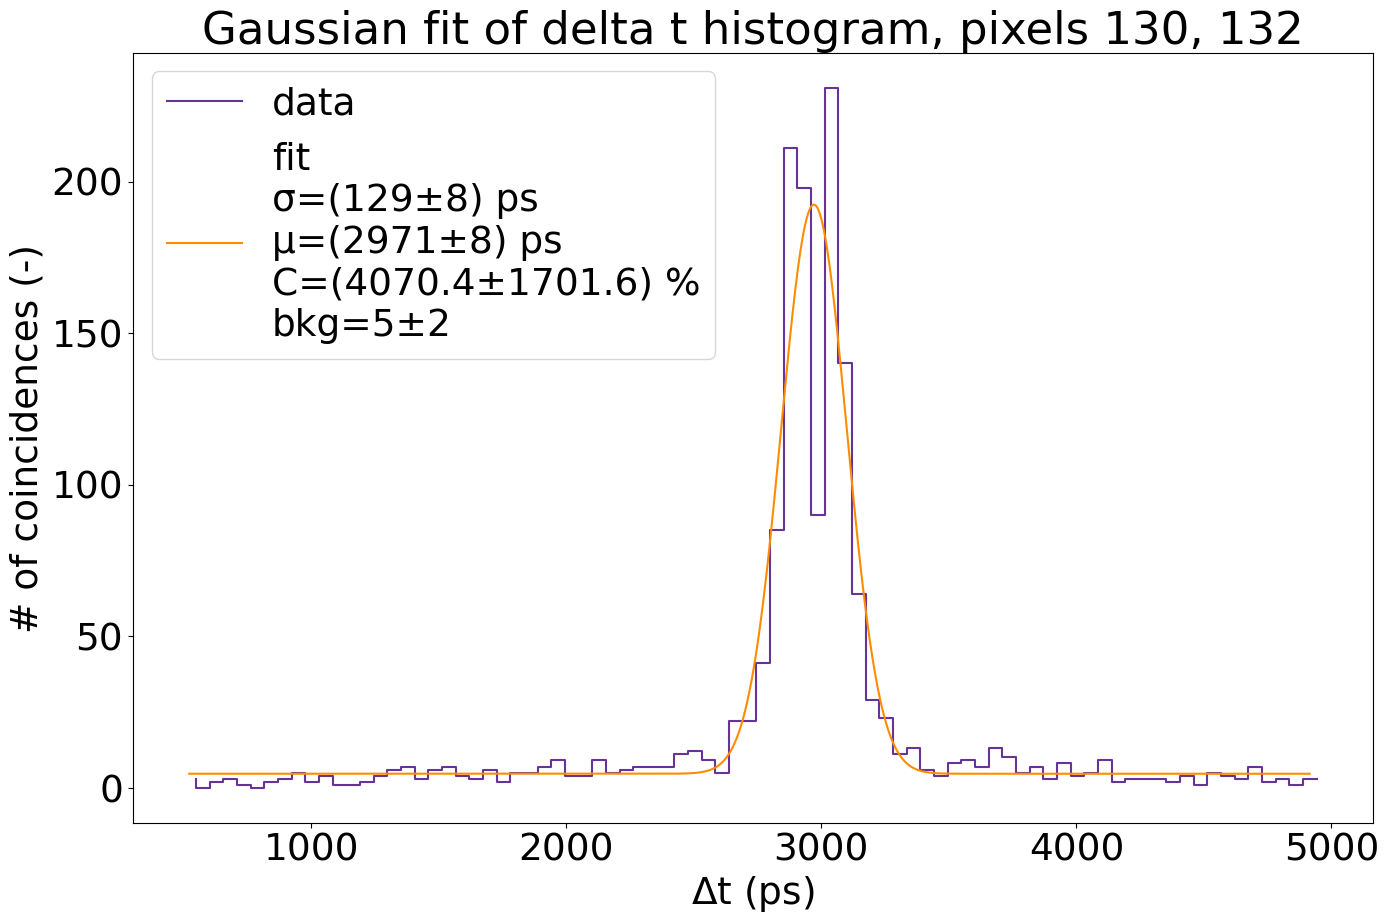

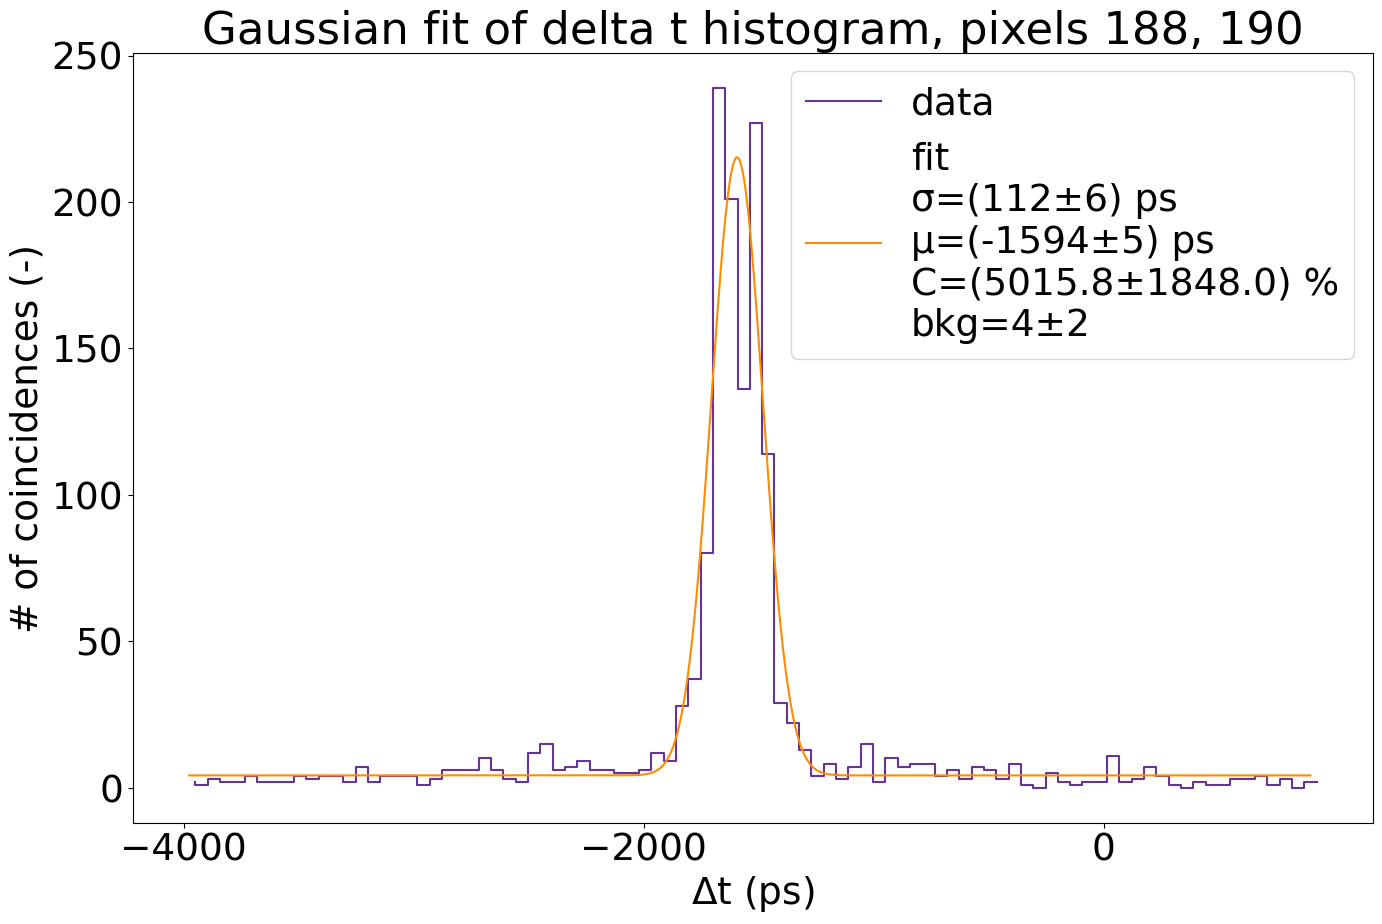

In [8]:
path_130_132 = (
    r"D:\LinoSPAD2\Data\B7d\2024.12.11\offset_w_LED\delta_ts_data\130,132"
)

fits.fit_with_gaussian(
    path_130_132,
    pixels=[130, 132],
    multiplier=3,
    ft_file=r"0000072934-0000073033.feather",
)

path_188_190 = (
    r"D:\LinoSPAD2\Data\B7d\2024.12.11\offset_w_LED\delta_ts_data\188,190"
)

fits.fit_with_gaussian(
    path_188_190,
    pixels=[188, 190],
    multiplier=3,
    ft_file=r"0000072934-0000073033.feather",
)

# Solving the Offset Equations using a Linear Matrix Equation

## Formulation of the System

We have the system of equations:

```math
(t_i + d_i) - (t_j + d_j) = d_i - d_j = 	off_{ij}, \quad i \in [0,254]. \quad j \in [1,255].
```
Here the t_i, t_j are timestamps, which for CT are the same as delta_t = 0. The equations simplify to known offset being equal to difference between the delays in propagation.

```math
\sum_{k=0}^{255} d_k = 0.
```

Rewriting this in matrix form:

```math
Ax = b
```

where:
- \( A \) is a bidiagonal matrix,
- \( x \) represents the unknown delays values,
- \( b \) is the vector of given offsets.

## Bidiagonal Matrix Structure

The system can be represented in matrix form as:
\begin{equation}
A = 
\begin{bmatrix}
1 & -1 & 0 & 0 & \cdots & 0 \\
0 & 1 & -1 & 0 & \cdots & 0 \\
0 & 0 & 1 & -1 & \cdots & 0 \\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & 0 & \cdots & -1 \\
1 & 1 & 1 & 1 & \cdots & 1
\end{bmatrix}
\end{equation}

```


Text(0, 0.5, 'Matrix row (-)')

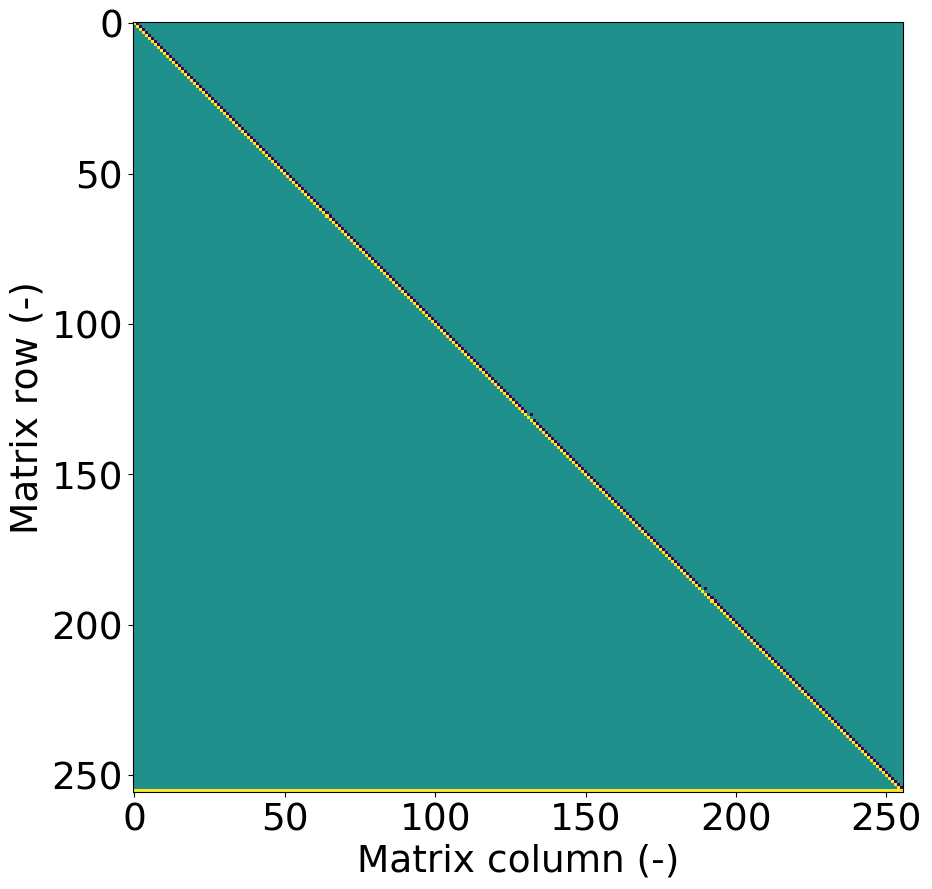

In [9]:
# Copy the peak positions as the right side of the system of equations
offsets = np.copy(mus)

# Append 0 to mus which will be for the sum = 0
offsets = np.append(offsets, 0)

A0 = np.eye(len(offsets))
A1 = -1 * np.eye(len(offsets), k=1)
A = A0 + A1

# The last row corresponds to the sum of all delays
A[-1] = 1

# We manually set the row 130 and 188, which will correspond to pairs 
# of pixels (130, 132) and (188, 190)
A[130][130] = 1
A[130][131] = 0 # cut the 131 out of equation
A[130][132] = -1
offsets[130] = 2971

A[188][188] = 1
A[188][189] = 0 # cut the 189 out of equation
A[188][190] = -1
offsets[188] = -1594

# Now we set the second equation where 131 and 189 appear to set their 
# offsets to 0
A[131][131] = 1
A[131][132] = 0
A[189][189] = 1
A[189][190] = 0


# Solve the system of equations
res = np.linalg.solve(A, offsets)

## For checking and debugging
# print(A)
# print(offsets)
# print(res[144])
# print(res[171])

# Save the files with the offsets
os.chdir(r"D:\LinoSPAD2\Data\B7d\2024.12.11\offset_w_LED")
np.save("Offset_B7d_#28_2212s.npy", res)

# Visualize the system of equations
plt.figure(figsize=(16,10))
plt.imshow(A, cmap='viridis')
plt.xlabel("Matrix column (-)")
plt.ylabel("Matrix row (-)")

We are done at this point, the offset calibration is complete. Now, we can plot the delays and their distribution.

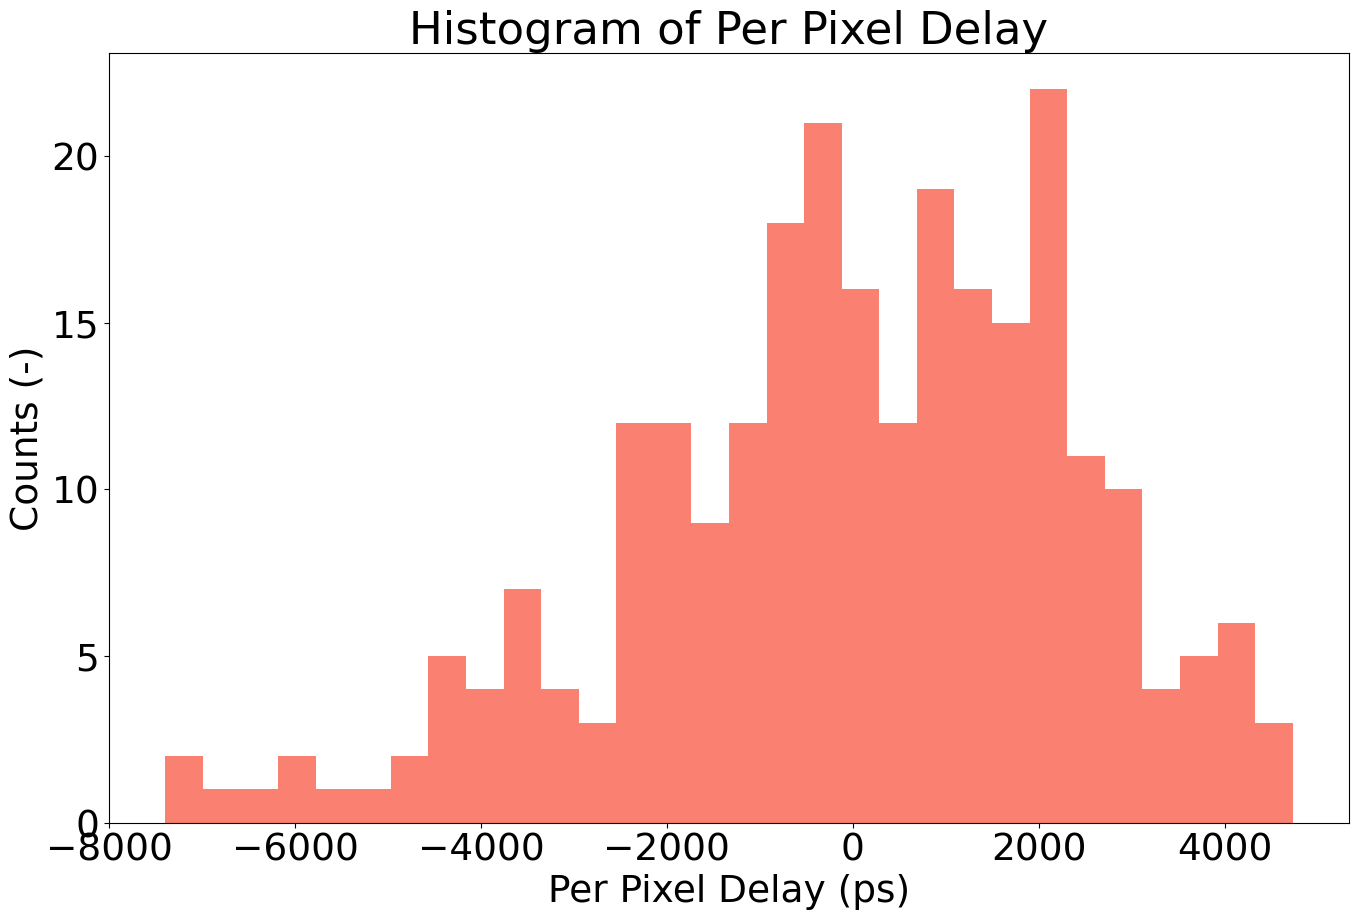

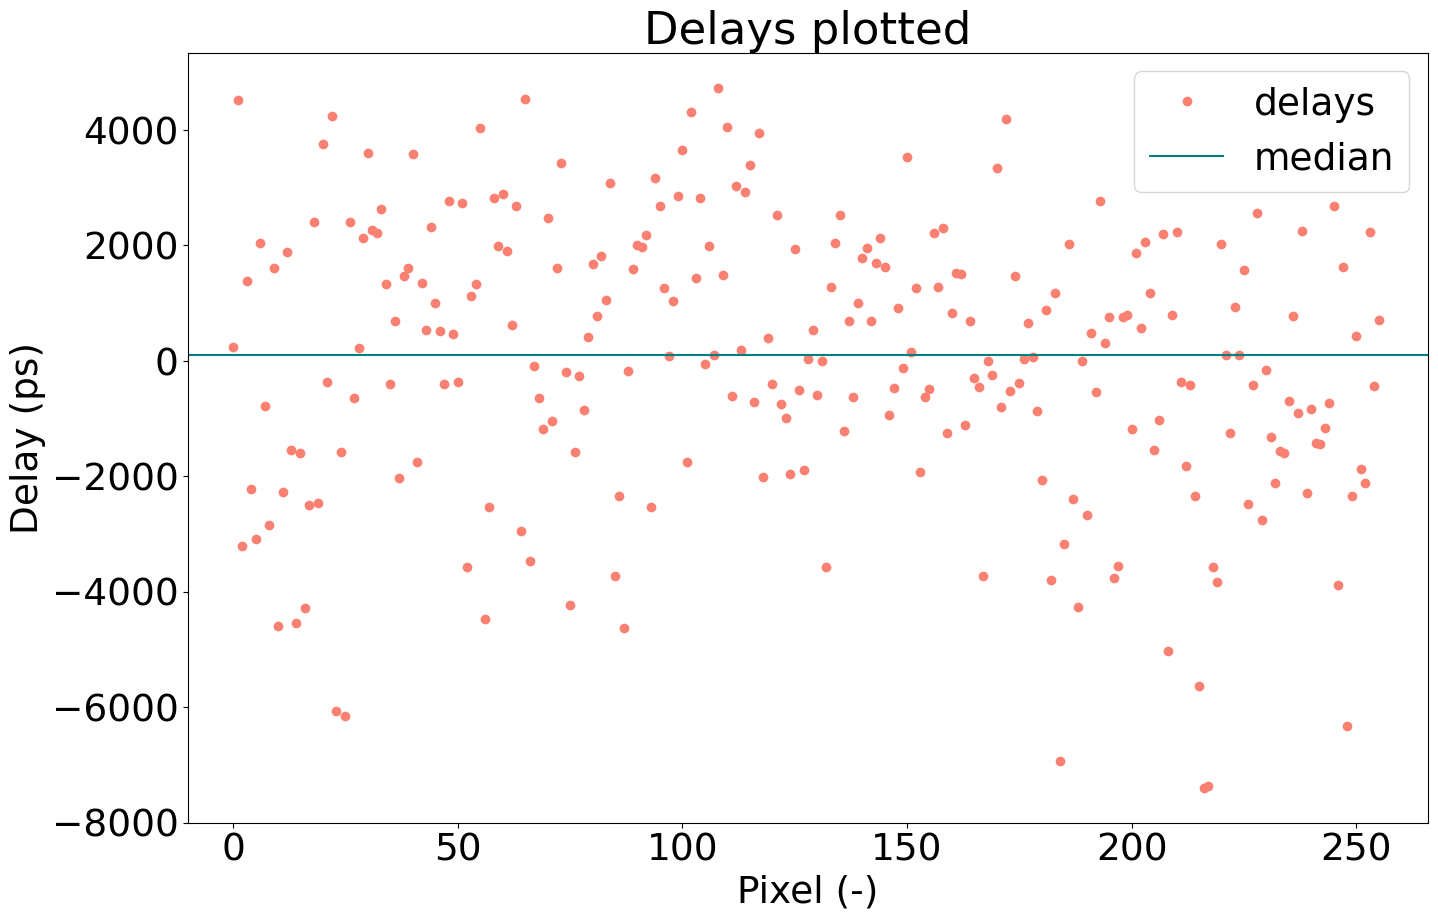

In [10]:
#Plot of all delays
os.chdir(path)

import matplotlib.pyplot as plt
delays = np.load("Offset_B7d_#28_2212s.npy")
plt.figure(figsize=(16, 10))
plt.hist(delays, bins=30, color="salmon")
plt.title("Histogram of Per Pixel Delay")
plt.xlabel("Per Pixel Delay (ps)")
plt.ylabel("Counts (-)")
plt.show()

plt.figure(figsize=(16, 10))
plt.plot(delays, 'o', color="salmon", label="delays")
plt.hlines(np.median(delays), -10e3, 10e3, color='teal', label='median')
plt.title("Delays plotted")
plt.xlabel("Pixel (-)")
plt.ylabel("Delay (ps)")
plt.xlim(-10, 266)
plt.legend(loc='best')
plt.show()

Here are a couple of examples of HBT and CT peaks after applying the offset calibration. The HBT peaks are shifted to approx. -5.2 ns position because of the additional 1 m optical fiber.

![alt text](0000010933-0000017129_pixels_144,171_fit-1.png)

![alt text](0000019000-0000019199_pixels_70,73_all_fit.png)

![alt text](0000007309-0000007408_delta_t_grid.png)